In [2]:
import pandas as pd
import numpy as np
import math
from numpy import sqrt, radians, arcsin, sin, cos
import matplotlib.pyplot as plt

In [5]:
    
'''
New method, which checks if a point lies on a segment
Used by the new method in the Polygon class
'''

class Point():
    # initialise
    def __init__(self, x=None, y=None):
        self.x = x
        self.y = y
    
    # representation
    def __repr__(self):
        return f'Point(x={self.x:.2f}, y={self.y:.2f})'

        # Test for equality between Points
    def __eq__(self, other): 
        if not isinstance(other, Point):
            # don't attempt to compare against unrelated types
            return NotImplemented
        return self.x == other.x and self.y == other.y

    # We need this method so that the class will behave sensibly in sets and dictionaries
    def __hash__(self):
        return hash((self.x, self.y))
    
    # calculate Euclidean distance between two points
    def distEuclidean(self, other):
        return sqrt((self.x-other.x)**2 + (self.y-other.y)**2)
    
    # calculate Manhattan distance between two points
    def distManhattan(self, other):
        return abs(self.x-other.x) + abs(self.y-other.y)

    # Haversine distance between two points on a sphere - requires lat/lng converted to radians
    def distHaversine(self, other):
        r = 6371000  # Earth's radius in metres (will return result in metres)
        phi1 = radians(self.y) # latitudes
        phi2 = radians(other.y)
        lam1 = radians(self.x) # longitudes
        lam2 = radians(other.x)

        d = 2 * r * arcsin(sqrt(sin((phi2 - phi1)/2)**2 + 
                                      cos(phi1) * cos(phi2) * sin((lam2 - lam1)/2)**2))
        return d   

    
    # Calculate determinant with respect to three points. Note the order matters here - we use it to work out left/ right in the next method
    def __det(self, p1, p2):
        det = (self.x-p1.x)*(p2.y-p1.y)-(p2.x-p1.x)*(self.y-p1.y)       
        return det

    def leftRight(self, p1, p2):
        # based on GIS Algorithms, Ch2, p11-12, by Ningchuan Xiao, publ. 2016
        # -ve: this point is on the left side of a line connecting p1 and p2
        #   0: this point is collinear
        # +ve: this point is on the right side of the line
        side = int(self.__det(p1, p2))
        if side != 0:
            side = side/abs(side)  # will return 0 if collinear, -1 for left, 1 for right
        return side

    def on_segment_euc(self, seg):
        if (self.__det(seg.start, seg.end)<=0):
            if (self.distEuclidean(seg.start)<=seg.length) and (self.distEuclidean(seg.end)<=seg.length):
                return True
        return False
  
    
####### Segment #######
class Segment():    
    # initialise
    def __init__(self, p0, p1):
        self.start = p0
        self.end = p1
        self.length = p0.distEuclidean(p1)
    
    # representation
    def __repr__(self):
        return f'Segment with start {self.start} and end {self.end}.' 

    # Test for equality between Segments - we treat segments going in opposite directions as equal here
    def __eq__(self, other): 
        if (self.start == other.start or self.start == other.end) and (self.end == other.end or self.end == other.start):
            return True
        else:
            return False
            # We need this method so that the class will behave sensibly in sets and dictionaries
    
    def __hash__(self):
        return hash((start.start.x, self.start.y,self.end.x, self.end.y))    
        
    # determine if intersects with another segment (using Point method leftRight)
    # - should we incorporate testing for identical segments and non-zero lengths?
    def intersects(self, other):        
        # create bounding boxes for each segment, using Bbox class
        self_bbox = Bbox(self)
        other_bbox = Bbox(other)

        # test if bounding boxes overlap (using Bbox method testOverlap)
        bbox_overlap = self_bbox.intersects(other_bbox)
               
        # if the two bboxes do not overlap, there can be no intersection        
        if bbox_overlap == False:
            return False
        
        else: # bboxes overlap, test if lines intersect or are collinear
            
            # find side for each point of each line in relation to the points of the other line
            apq = self.start.leftRight(other.start, other.end)
            bpq = self.end.leftRight(other.start, other.end)
            pab = other.start.leftRight(self.start, self.end)
            qab = other.end.leftRight(self.start, self.end)           
            
            # leftRight sums to 0 for both segments if they intersect (+1/-1) or are collinear (0/0)
            if (apq + bpq == 0 and pab + qab == 0): 
                return True
            else:
                return False      
            
'''
New Linestring class
Implemented, because Line-Segment-Intersection is needed.
'''

class Linestring():
    
    def __init__(self, data, xcol=0, ycol=1):
        self.points = []
        for d in data:
            self.points.append(Point(d[xcol], d[ycol]))
        
    def string_segment_intersection(self, other_seg):
        for i in range(len(self.points)-1):
            #print(range(len(self.points)-1))
            seg = Segment(self.points[i], self.points[i+1])
            if other_seg.intersects(seg)==True:
                #print("Start and end of new: ", other_seg.start, other_seg.end)
                #print("Start and end of old: ", seg.start, seg.end)
                if (other_seg.start != seg.end and other_seg.end !=seg.start):
                    return True
        return False
                
           
            
        
        
####### Bounding Box #######    

# define bounding box for 2 or more points (initialised as PointGroup, Polygon or Segment)
class Bbox():
    
    # initialise
    def __init__(self, data):
    # using built-in `isinstance` to test what class has been used to initialise the object   

        # for Segment objects 
        if isinstance(data, Segment) == True:
            x = [data.start.x, data.end.x]
            y = [data.start.y, data.end.y]
        
        # for PointGroup objects (including Polygon)
        else:      
            x = [i.x for i in data]   # extract all x coords as a list
            y = [i.y for i in data]   # extract all y coords as a list

        # determine corners, calculate centre and area
        self.ll = Point(min(x), min(y))    # lower-left corner (min x, min y)
        self.ur = Point(max(x), max(y))    # upper-right corner (max x, max y)
        self.ctr = Point((max(x)-min(x))/2, (max(y)-min(y))/2)   # centre of box
        self.area = (abs(max(x)-min(x)))*abs((max(y)-min(y)))    # area of box
           
    # representation
    def __repr__(self):
        return f'Bounding box with lower-left {self.ll} and upper-right {self.ur}' 
    
    def __eq__(self, other): 
        if (self.ll == other.ll and self.ur == other.ur):
            return True
        else:
            return False
            # We need this method so that the class will behave sensibly in sets and dictionaries
    
    def __hash__(self):
        return hash(self.ll, other.ur)  
        
    # test for overlap between two bounding boxes
    def intersects(self, other):       
        # test if bboxes overlap (touching is not enough to be compatible with the approach to segments)
        if (self.ur.x > other.ll.x and other.ur.x > self.ll.x and
            self.ur.y > other.ll.y and other.ur.y > self.ll.y):
            return True
        else:
            return False
        
    # Check if bounding box is contained by this one     
    def contains(self, other):
        if (self.ur.x >= other.ur.x and self.ll.x <= other.ll.x and
            self.ur.y >= other.ur.y and self.ll.y <= other.ll.y):
            return True
        else:
            return False
        
    def intersectsRegion(self, other):
        if self == other:
            return self
        elif self.contains(other):
            return other
        elif self.intersects(other):
            llx = max(self.ll.x, other.ll.x)
            lly = max(self.ll.y, other.ll.y)
            urx = min(self.ur.x, other.ur.x)
            ury = min(self.ur.y, other.ur.y)
            return Bbox([Point(llx, lly), Point(urx, ury)])
        else:
            return None
                        
    # contains includes points on boundaries, otherwise we have problems when points are used to define
    # box but not in it
    def containsPoint(self, p):
        if (self.ur.x >= p.x and p.x >= self.ll.x and
            self.ur.y >= p.y and p.y >= self.ll.y):
            return True
        return False
        

# FOR GROUPS OF POINTS

# data provided should be as an array of points with x, y coordinates.

# class for a group of Points, assumes initial data is unsorted, spatially
class PointGroup(): 
    # initialise
    def __init__(self, data=None, xcol=None, ycol=None):
        self.points = []
        self.size = len(data)
        for d in data:
            self.points.append(Point(d[xcol], d[ycol]))
    
    # representation
    def __repr__(self):
        return f'PointGroup containing {self.size} points' 
 
    # create index of points in group for referencing
    def __getitem__(self, key):
        return self.points[key]
    

'''
New method (IntersectsPoint), which check if a polygon intersects with a point
'''

# Polygon class for polygons, assumes initial data is in a spatially sorted order
class Polygon(PointGroup):  
    # initialise
    def __init__(self, data=None, xcol=None, ycol=None):
        self.points = []
        self.size = len(data)
        for d in data:
            self.points.append(Point(d[xcol], d[ycol]))
        self.bbox = Bbox(self)
        
    # representation
    def __repr__(self):
        return f'Polygon PointGroup containing {self.size} points' 
  
    # test if polygon is closed: first and last point should be identical
    def isClosed(self):
        start = self.points[0]
        end = self.points[-1]
        return start == end

    def removeDuplicates(self):
        oldn = len(self.points)
        self.points = list(dict.fromkeys(self.points)) # Get rid of the duplicates
        self.points.append(self.points[0]) # Our polygon must have one duplicate - we put it back now
        n = len(self.points)
        print(f'The old polygon had {oldn} points, now we only have {n}.')
        
        # find area and centre of the polygon
    # - based on GIS Algorithms, Ch.2 p9-10, by Ningchuan Xiao, publ. 2016 
    
    def __signedArea(self):  # used for both area and centre calculations - this is a private method (only used within the class)
        a = 0
        xmean = 0
        ymean = 0
        for i in range(0, self.size-1):
            ai = self[i].x * self[i+1].y - self[i+1].x * self[i].y
            a += ai
            xmean += (self[i+1].x + self[i].x) * ai
            ymean += (self[i+1].y + self[i].y) * ai

        a = a/2.0   # signed area of polygon (can be a negative)
    
        return a, xmean, ymean
    
    def area(self):
        a, xmean, ymean = self.__signedArea()
        area = abs(a)   # absolute area of polygon
        
        return area

    def centre(self):
        a, xmean, ymean = self.__signedArea() # note we use the signed area here
        centre = Point(xmean/(6*a), ymean/(6*a)) # centre of polygon 
        return centre

    def containsPoint(self, p):
        if (self.bbox.containsPoint(p) == False):
            return False
        
        # Solution, as discussed in lecture, added here
        ray = Segment(p, Point(self.bbox.ur.x+1, p.y))
        count = 0
        
        for i in range(0, self.size-1):
            start = self[i]
            end = self[i+1]
            if (start.y != end.y): 
                if ((p.x < start.x) and (p.y == start.y)): 
                    count = count + 1
                else:
                    s = Segment(start, end)
                    if s.intersects(ray):
                        count = count + 1
              
        if (count%2 == 0):
            return False           

        return True

    def intersectsPoint(self, p):
        if (self.containsPoint(p)==True):
            return True
        for i in range(len(self.points)-1):
            if p.on_segment_euc(Segment(self.points[i], self.points[i+1]))==True:
                return True
            else:
                next
        return False

In [6]:
"""
Point-Buffer
inputs:
- points: list of tuples with x and y coordinates
- buffer_size: size of buffer as float or int
output:
- list of points (not ordered)
"""
def buffer_points(points, buffer_size):
    buffered_points = []
    for point in points:
        x = point.x
        y = point.y
        
        # Create a circle of points around the original point
        angles = np.linspace(0, (2-2/50)*np.pi, num=6)
        circle_points = [Point(x + buffer_size*np.cos(a), y + buffer_size*np.sin(a)) for a in angles]
        
        buffered_points += circle_points
    
    return buffered_points

In [7]:
class ConcaveHull(object):

    def __init__(self, points, k):
        if isinstance(points, np.core.ndarray):
            self.data_set = points
        elif isinstance(points, list):
            self.data_set = np.array(points)
        else:
            raise ValueError('Please provide an [N,2] numpy array or a list of lists.')

        # Clean up duplicates
        self.data_set = np.unique(self.data_set, axis=0)

        # Create the initial index
        self.indices = np.ones(self.data_set.shape[0], dtype=bool)  # bool of a column of all 1's

        self.k = k

    @staticmethod
    def dist_pt_to_group(a, b):  # a is a (n,2) , b is (1,2) arrays
        d = np.sqrt(np.sum(np.square(np.subtract(a, b)), axis=1))
        return d

    @staticmethod
    def get_lowest_latitude_index(points):
        indices = np.argsort(points[:, 1])
        return indices[0]

    @staticmethod
    def norm_array(v):  # normalize row vectors in an array. observations are rows
        norms = np.array(np.sqrt(np.sum(np.square(v), axis=1)), ndmin=2).transpose()
        return np.divide(v, norms)

    @staticmethod
    def norm(v):  # normalize a single vector, is there an existing command?
        norms = np.array(np.sqrt(np.sum(np.square(v))))
        return v / norms

    def get_k_nearest(self, ix, k):
        """
        Calculates the k nearest point indices to the point indexed by ix
        :param ix: Index of the starting point
        :param k: Number of neighbors to consider
        :return: Array of indices into the data set array
        """
        ixs = self.indices
        # base_indices is list of linear indicies that are TRUE, ie part of dataset
        base_indices = np.arange(len(ixs))[ixs]
        distances = self.dist_pt_to_group(self.data_set[ixs, :], self.data_set[ix, :])
        sorted_indices = np.argsort(distances)

        kk = min(k, len(sorted_indices))
        k_nearest = sorted_indices[range(kk)]
        return base_indices[k_nearest]

    def clockwise_angles(self, last, ix, ixs, first):  # last needs to be the index of the previous current point
        if first == 1:
            last_norm = np.array([-1, 0], ndmin=2)
        elif first == 0:
            last_norm = self.norm(np.subtract(self.data_set[last, :], self.data_set[ix,:]))  # normalized vector pointing towards previous point
        ixs_norm = self.norm_array(np.subtract(self.data_set[ixs, :], self.data_set[ix,:]))  # normalized row vectors pointing to set of k nearest neibs
        ang = np.zeros((ixs.shape[0], 1))
        for j in range(ixs.shape[0]):
            theta = np.arccos(np.dot(last_norm, ixs_norm[j, :]))
            # ang[j,0] = theta
            z_comp = np.cross(last_norm, ixs_norm[j, :])
            # ang[j,2] = z
            if z_comp <= 0:
                ang[j, 0] = theta
            elif z_comp > 0:
                ang[j, 0] = 2 * np.pi - theta
        return np.squeeze(ang)

    def recurse_calculate(self):
        """
        Calculates the concave hull using the next value for k while reusing the distances dictionary
        :return: Concave hull
        """
        recurse = ConcaveHull(self.data_set, self.k + 1)
        if recurse.k >= self.data_set.shape[0]:
            print(" max k reached, at k={0}".format(recurse.k))
            return None
        print("k={0}".format(recurse.k))
        return recurse.calculate()

    def calculate(self):
        """
        Calculates the convex hull of the data set as an array of points
        :return: Array of points (N, 2) with the concave hull of the data set
        """
        if self.data_set.shape[0] < 3:
            return None

        if self.data_set.shape[0] == 3:
            return self.data_set

        # Make sure that k neighbors can be found
        kk = min(self.k, self.data_set.shape[0])

        first_point = self.get_lowest_latitude_index(self.data_set)
        current_point = first_point
        # last_point = current_point # not sure if this is necessary since it wont get used until after step 2

        # Note that hull and test_hull are matrices (N, 2)
        hull = np.reshape(np.array(self.data_set[first_point, :]), (1, 2))
        test_hull = hull

        # Remove the first point
        self.indices[first_point] = False

        step = 2
        stop = 2 + kk

        while ((current_point != first_point) or (step == 2)) and len(self.indices[self.indices]) > 0:  # last condition counts number of ones, points in dataset
            if step == stop:
                self.indices[first_point] = True
            # notice how get_k_nearest doesnt take the data set directly as an arg, as it is implicit that it takes self as an imput because we are inside a class:
            knn = self.get_k_nearest(current_point, kk)  # knn = [3,6,2] or [0,2,7] etc indicies into the full dataset (with no points removed)

            if step == 2:
                angles = self.clockwise_angles(1, current_point, knn, 1)
            else:
                # Calculates the headings between first_point and the knn points
                # Returns angles in the same indexing sequence as in knn
                angles = self.clockwise_angles(last_point, current_point, knn, 0)

            # Calculate the candidate indexes (largest angles first). candidates =[0,1,2]  or [2,1,0] etc if kk=3
            candidates = np.argsort(-angles)

            i = 0
            invalid_hull = True
            geospatial_invalid_hull = True
            while geospatial_invalid_hull and i < len(candidates):
                candidate = candidates[i]
                
                # Create a test hull to check if there are any self-intersections
                next_point = np.reshape(self.data_set[knn[candidate], :], (1, 2))
                geospatial_test_hull = hull
                line = Linestring(geospatial_test_hull)
                geospatial_invalid_hull = line.string_segment_intersection(Segment(Point(geospatial_test_hull[-1,0], geospatial_test_hull[-1,1]), Point(next_point[:, 0][0], next_point[:, 1][0])))  
                # invalid_hull will remain True for every candidate which creates a line that intersects the hull. as soon as the hull doesnt self intersect, it will become false and the loop will terminate
                i += 1

            if geospatial_invalid_hull:
                print("invalid hull for all nearest neibs")
                return self.recurse_calculate()

            last_point = current_point  # record last point for clockwise angles
            current_point = knn[candidate] # candidate = 0, 1, or 2 if kk=3
            hull = np.append(geospatial_test_hull, next_point, axis=0)

            self.indices[current_point] = False # we remove the newly found current point from the "mask" indicies so that it wont be passed to get_k_nearest (within the implicit input, self)
            step += 1
            
        
        poly = Polygon(hull, 0, 1)
        count = 0
        total = self.data_set.shape[0]
        for ix in range(total):
            #CHANGE1
            pt = Point(self.data_set[ix, 0], self.data_set[ix, 1])
            if (poly.intersectsPoint(pt)): 
                count += 1
            else:
                print("point not in polygon")

        if count == total:
            return hull
        else:
            return self.recurse_calculate()

In [8]:
'''
(Linestring-)Buffer
Combines point buffer function and concave hull method

inputs:
- node: List of Point objects, which represent a linestring
- dist: Size of Buffer in meters (e.g. 200)
- nn: With how many nearest neighbors the calculation should start (recommended: 20)
- reduction: By how much the linstring should be reduced (e.g. 50 means, the algorithm will take into account
every 50th point of the linestring)

output:
- [n, 2]-array (in first position x-coordinate, in second position y-coordinate)

'''

def buffer(nodes,dist, nn, reduction = 0):
    #Reduction of nodes
    if reduction!=0:
        nodes = nodes[::50]
    node_buffer = buffer_points(nodes, dist)
    
    #Creates a list of lists as input for concave hull class
    node_buffer_list = [[node.x, node.y] for node in node_buffer]
    
    #Calculate hull
    hull_object = ConcaveHull(node_buffer_list,nn)
    hull = hull_object.calculate()
    
    return hull

## Demo

In [9]:
#Loading sample data from disk
myHighway = pd.read_csv("data\A1Sample_20230529_nnitsi.csv")

#Transform into suitable input
highway_nodes = []
for index, row in myHighway.iterrows():
    obj = Point(row['x'], row['y'])
    highway_nodes.append(obj)

#Function call
sample = buffer(highway_nodes,500,20, 50)
type(sample)

numpy.ndarray

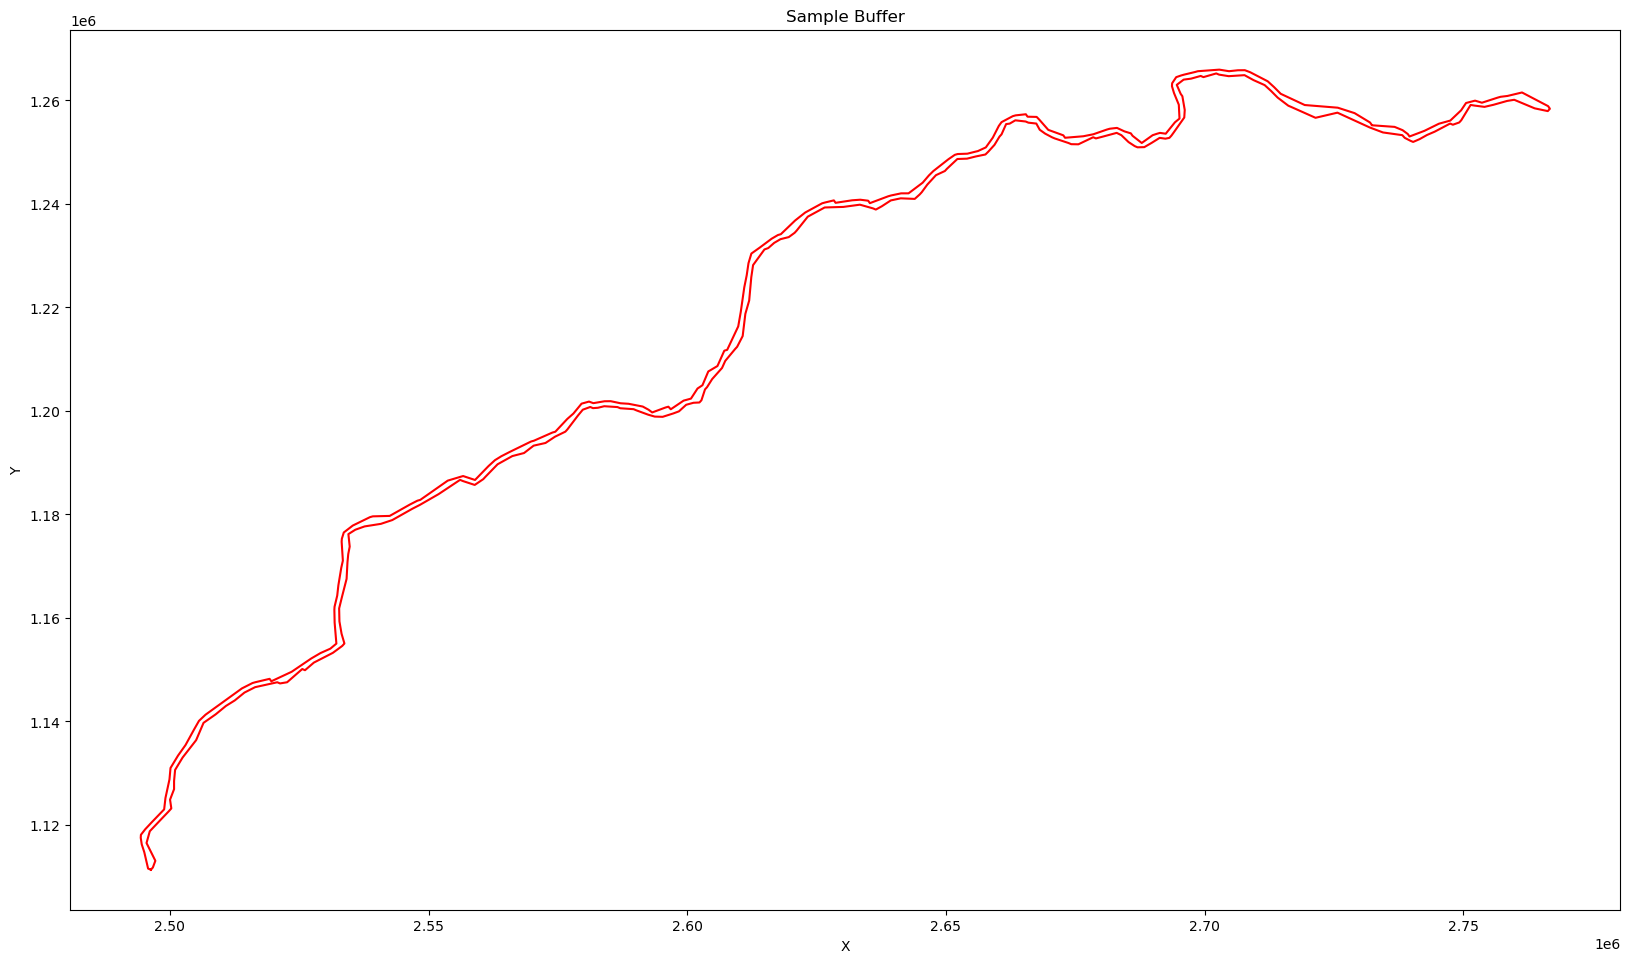

In [10]:
fig, ax0 = plt.subplots(figsize = (20,20))

ax0.plot(sample[:, 0], sample[:, 1], color = 'red')

ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.set_title('Sample Buffer')
ax0.set_aspect('equal')